In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
from scipy.integrate import quad

In [3]:
X = pd.read_csv("parental_anxiety_vs_kids_age.csv").to_numpy()

In [4]:
X.shape

(10000, 1)

1) Use KDE to find p(x)

In [5]:
def gaussian(mean, var, x):
    return np.exp(-0.5 * ((x - mean) / var)**2) / (var * np.sqrt(2*math.pi))

/var/folders/xm/v8qzdms97jgglrj50ntk80hr0000gn/T/ipykernel_39822/2444859084.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu = float(subset_X)


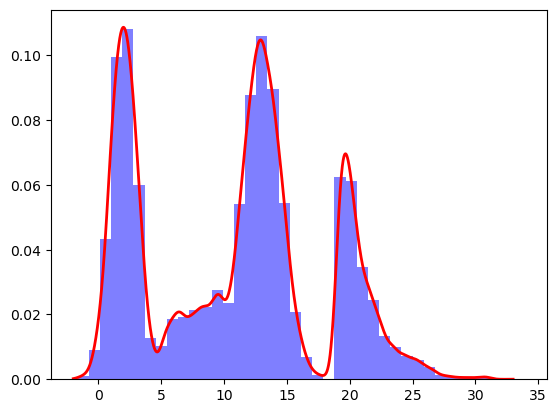

In [6]:
n, bins, patches = plt.hist(X, 40, facecolor='blue', alpha=0.5, density=True)
def compute_KDE(X,x):
    ind_start = 0
    ind_current = 1
    overall_pdf = 0
    num_gaussians = 0
    complete_pdf  = 0
    for i in range(X.shape[0]):
        subset_X = X[ind_start:ind_current]
        if subset_X.size == 0:
            break
        else: 
            mu = float(subset_X)
            sigma = 0.4
            pdf = (gaussian(mu, sigma, x))
            num_gaussians += 1
            overall_pdf += pdf
            ind_start = ind_current
            ind_current += 1
    complete_pdf = overall_pdf / num_gaussians
    return complete_pdf


x = np.linspace(-2, 33, 10000)
plt.plot(x, compute_KDE(X,x), 'r-', linewidth = 2)
plt.show()

# Polynomial Regression Closed Form Method

In [7]:
from sklearn.preprocessing import PolynomialFeatures

In [8]:
sampled_indices = np.random.choice(X.shape[0], size=500, replace=False)
X_sample = X[sampled_indices]

In [33]:
poly = PolynomialFeatures(degree=7)
X_poly = poly.fit_transform(X_sample)
y = compute_KDE(X_sample, np.linspace(-2, 33, 500))
w_poly = np.linalg.inv(np.dot(X_poly.T,X_poly)).dot(X_poly.T.dot(y))

/var/folders/xm/v8qzdms97jgglrj50ntk80hr0000gn/T/ipykernel_39822/2444859084.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu = float(subset_X)


/var/folders/xm/v8qzdms97jgglrj50ntk80hr0000gn/T/ipykernel_39822/2444859084.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu = float(subset_X)


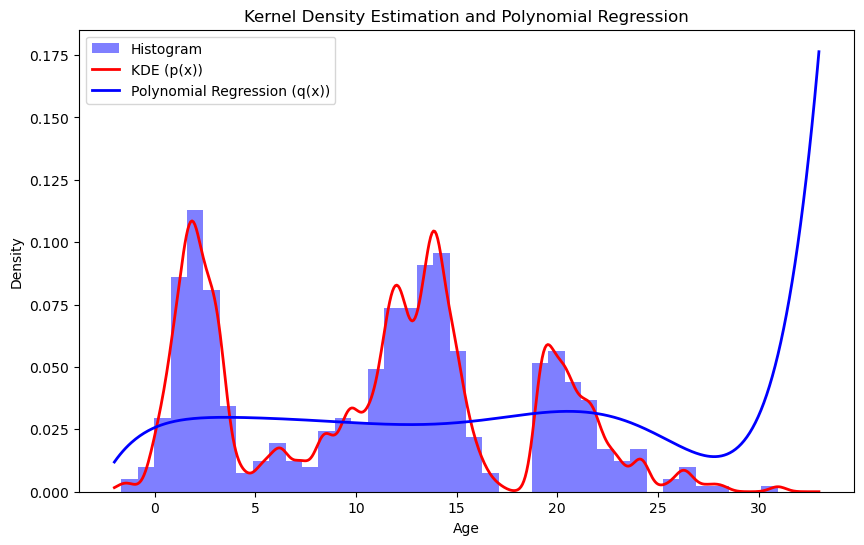

In [34]:
# Evaluate polynomial function at sampled points
x_values_sampled = np.linspace(-2, 33, 500)
X_values_poly_sampled = poly.fit_transform(x_values_sampled.reshape(-1, 1))
y_values_poly_sampled = X_values_poly_sampled.dot(w_poly)

plt.figure(figsize=(10, 6))

# Plot histogram using X_sample
n, bins, patches = plt.hist(X_sample, 40, facecolor='blue', alpha=0.5, density=True, label='Histogram')

# Plot KDE
plt.plot(x_values_sampled, compute_KDE(X_sample, x_values_sampled), 'r-', linewidth=2, label='KDE (p(x))')

# Plot polynomial regression approximation
plt.plot(x_values_sampled, y_values_poly_sampled, 'b-', linewidth=2, label='Polynomial Regression (q(x))')

plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.title('Kernel Density Estimation and Polynomial Regression')
plt.show()

# Kernel Regression Closed Form

In [11]:
# Forming Kernel Matrix using Gaussian Kernel 
def k(x_i, x_j, γ):
    norm_sq = (np.linalg.norm(x_i - x_j))**2
    kernel = math.e ** (-γ * norm_sq)
    return kernel

kernel_matrix = np.array([])
for x_i in X_sample:
    row = []
    for x_j in X_sample:
        k_x_x = k(x_i , x_j, 0.005)
        row.append(k_x_x)
    if len(kernel_matrix) == 0:
        kernel_matrix = np.array([row])
    else:
        kernel_matrix = np.vstack((kernel_matrix, row))


In [12]:
alpha = np.linalg.inv(np.dot(kernel_matrix.T,kernel_matrix)).dot(kernel_matrix.T.dot(y))

In [35]:
# Obtaining y predictions
sum_list = []
for x in X_sample:
    sum = 0
    for i in range(X_sample.shape[0]):
        kernel_val = k(x ,X_sample[i], 0.005)
        alpha_times_kernel = alpha[i] * kernel_val
        sum += alpha_times_kernel
    sum_list.append(sum)

y_pred = np.array(sum_list)


# Kernel Ridge Regression Closed Form

In [13]:
λ = 0.01
kernel_ridge_y_pred = kernel_matrix.dot(np.linalg.inv(kernel_matrix + λ*np.eye(500))).dot(y)